In [1]:
# This is its own cell because it takes a while to load this thing
from gensim import models

# takes a little bit. increase limit at own risk.
# model = models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True, limit=500000)  
model = models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True, limit=500000)  

In [999]:
# imports and list of scrape times.

import pandas as pd
import sklearn
import requests
import json
import _pickle as pickle
import os
import numpy as np
import time
import shutil
import datetime
import cv2
import urllib.request
import sqlite3 as sql
import base64
import ffmpy3
from file_read_backwards import FileReadBackwards
import string
from nltk.corpus import stopwords
import json
from textblob import TextBlob
from nltk.data import load
import nltk
from urllib.error import HTTPError

import xml
import xml.dom.minidom



list_of_scrape_times = []

In [1183]:
## class Loader

class Loader:
    def __init__(self, list_of_ids = [], list_of_times = []):
        self.list_of_ids = list_of_ids
        self.list_of_times = list_of_times
    
    filedir = ""

    ## 'file' omitted because it's not used in generating features
    list_of_types = ['text','log','contact','calender','gps','tweets','Instagram', 'Instagram media', 'audio','phq']
    
    def deletdatboi(self, nombre):
        shutil.rmtree('./datafor' + list_of_scrape_times[nombre])
        
    def lids(self):
        # connect to file
        conn = sql.connect('phonedata.db')
        # create cursor for making calls to database
        c = conn.cursor()

        list_of_approved_ids = []
        text_file = open("final_codes.txt", "r")
        list_of_approved_ids = text_file.read().split('\n')
        del list_of_approved_ids[-1]
        
        self.list_of_ids = []
        
        for row in c.execute('SELECT * FROM ids'):
            # one result
            if (row[0] in list_of_approved_ids):
                self.list_of_ids.append(row[0])
        
        return self.list_of_ids
    
    def lits(self):
        # connect to file
        conn = sql.connect('phonedata.db')
        # create cursor for making calls to database
        c = conn.cursor()

        list_of_approved_ids = []
        text_file = open("final_codes.txt", "r")
        list_of_approved_ids = text_file.read().split('\n')
        del list_of_approved_ids[-1]
        
        self.list_of_times = []
        
        for row in c.execute('SELECT * FROM ids'):
            # one result
            if (row[0] in list_of_approved_ids):
                self.list_of_times.append(row[1])
    
        return self.list_of_times
    
    def downloadAndLabel(self):
        # connect to file
        conn = sql.connect('phonedata.db')
        # create cursor for making calls to database
        c = conn.cursor()

        self.list_of_ids = []
        
        for row in c.execute('SELECT * FROM ids'):
            # one result
            self.list_of_ids.append(row[0])
            self.list_of_times.append(row[1])

        number_cols = len(self.list_of_types)
        number_rows = len(self.list_of_ids)

        ### create directory for this particular scrape/pull
        timenow  = str(int(time.time())) # for temporal congruency
        timereadable = datetime.datetime.fromtimestamp(int(timenow)).strftime('%H:%M')
        list_of_scrape_times.append(timereadable)
        os.mkdir('./datafor' + timereadable)
        Loader.filedir = './datafor' + timereadable

        # alex gave me a list of approved mturk ids
        list_of_approved_ids = []
        text_file = open("final_codes.txt", "r")
        list_of_approved_ids = text_file.read().split('\n')
        del list_of_approved_ids[-1]
        
        for i in range(0,number_rows):
            for j in range(0,number_cols):
                
                if (self.list_of_ids[i] not in list_of_approved_ids):
                    break
                
                apickle = []

                exampleLookup = (self.list_of_ids[i], self.list_of_types[j])
                for row in c.execute('SELECT DISTINCT* FROM data WHERE id=? AND type=?', exampleLookup):
                    # the row with the ID, type, and content
                    apickle.append(row[2])
                    
                    # WEIRD: duplicate ids in data table with different data
                    if exampleLookup[1] == "phq" or exampleLookup[1] == "audio":
                        break

                ## if there is data, there is data
                ## if there is no data, there is no data
                if(len(apickle) != 0):
                    pickle.dump(apickle, open( Loader.filedir  + "/DP" + self.list_of_ids[i] +  self.list_of_types[j] + ".p", "wb" ))

        
        ## OLD CODE FOR INTERFACING THROUGH THE WEBSERVER
        ## CODE ABOVE ACCESSES A .DB FILE LOCALLY
        '''
        
        r = requests.get('http://depressionmqp.wpi.edu:8080/getids')
        list_of_idtime = r.json()
        

        for i in range(0,len(list_of_idtime)):
            self.list_of_ids.append( list_of_idtime[i]['id'].encode('ascii','ignore') )

        for i in range(0,len(list_of_idtime)):
            self.list_of_times.append( list_of_idtime[i]['date'] )

        number_cols = len(self.list_of_types)
        number_rows = len(self.list_of_ids)
        
        ### create directory for this particular scrape/pull
        timenow  = str(int(time.time())) # for temporal congruency
        timereadable = datetime.datetime.fromtimestamp(int(timenow)).strftime('%H:%M')
        list_of_scrape_times.append(timereadable)
        os.mkdir('./datafor' + timereadable)
        Loader.filedir = './datafor' + timereadable


        for i in range(0,number_rows):
            for j in range(0,number_cols):
                
                temp = requests.get('http://depressionmqp.wpi.edu:8080/getdata?id=' + str(int(self.list_of_ids[i])) + '&type=' + self.list_of_types[j])
                fintemp = json.loads(temp.text)["data"]
                
                while(json.loads(temp.text)["nextURL"] != ''):
                    temp = requests.get('http://depressionmqp.wpi.edu:8080' + json.loads(temp.text)["nextURL"])
                    fintemp += json.loads(temp.text)["data"]
                
                pickle.dump(fintemp, open( Loader.filedir + "/DP" + str(int(self.list_of_ids[i])) +  self.list_of_types[j] + ".p", "wb" ))

                # loads it into memory. i will not use this for now
                # for sake of architectural sanity
                # list_of_jsons[i][j] = temp
        '''

In [1181]:
## Featurizer featurizes methods that convert json objects of the appropriate type into features

class Featurizer:
    def __init__(self):
        pass
        #self.name = name

    # takes in text pickle and scrapedate, returns vector of 14 elements
    # the first element is count of texts sent in the 24 hours before the scrape
    # the last element is count of texts sent on the 24 hour window 14 days before the scrapedate
    def textFreqVec14(self, text, scrapedate):
        
        textFreqVec = np.zeros((14,))
        
        # moving average index
        n = 5
    
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # assuming unordered texts (WHICH TURNS OUT IS THE CASE)
        for day in range(0,14):
            time_during_week_ub = scrapedate - ((day)*mseconds_in_day)    
            time_during_week_lb = scrapedate - ((day+n)*mseconds_in_day)
            for t in range(0,len(text)):
                text_date = int(json.loads(text[t])['date'].encode('ascii','ignore'))
                if ((time_during_week_ub > text_date) and (text_date > time_during_week_lb)):
                    textFreqVec[day] += 1.0
                    
        return textFreqVec/n
    

    # takes in call pickle and scrapedate, returns vector of 14 elements
    # the first element is count of calls sent in the 24 hours before the scrape
    # the last element is count of calls sent on the 24 hour window 14 days before the scrapedate
    def callFreqVec14(self, call, scrapedate):
        
        callFreqVec = np.zeros((14,))
        
        # moving average index
        n = 5
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        for day in range(0,14):
            time_during_week_ub = scrapedate - ((day)*mseconds_in_day)    
            time_during_week_lb = scrapedate - ((day+n)*mseconds_in_day)
            for c in range(0,len(call)):
                call_date = int(json.loads(call[c])['date'].encode('ascii','ignore'))
                if ((time_during_week_ub > call_date) and (call_date > time_during_week_lb)):
                    callFreqVec[day] += 1.0
                    
        return callFreqVec/n
    
    
    # input is tweets pickle, return master vector
    def embeddingToMastersum(self, tweets):
        
        masterSum = np.zeros((300,))

        # add every word vector into master sum
        for i in range(0,len(tweets)):
            try:
                masterSum += self.tweetToEmbedding(tweets[i])
            except:
                pass
        
        return masterSum

    
    # input is one single tweet, returns vector embedding of entire tweet.
    # eg: responseobject.json()[0]
    def tweetToEmbedding(self, tweet):

        q = tweet['text'].split()
        
        sumVector = np.zeros((300,))
        
        # turn every word into embedding for 1 tweet, add all vectors
        for i in range(0,len(q)):
            try:
                sumVector += model[q[i]]
            except KeyError:
                pass
            except IndexError:
                pass
        
        return sumVector
    
    
    # input is tweets pickle, returns follow count
    def followerCount(self, tweets):

        followerCount = 0

        try:
            followerCount = json.loads(tweets[0])['user']['followers_count']
        except KeyError:
            pass
        except IndexError:
            pass

        return followerCount

    # input is tweets pickle, returns friend count
    def followingCount(self, tweets):

        followingCount = 0
        
        try:
            followingCount = json.loads(tweets[0])['user']['friends_count']
        except KeyError:
            pass
        except IndexError:
            pass

        return followingCount

    # input is tweets pickle, return avg likes per post for the last 2 weeks
    def twitterLikeFreq(self, tweets, scrapedate):

        twitLikeVec = np.zeros((1,))
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # upper and lower bounds
        time_during_week_ub = scrapedate - ((0)*mseconds_in_day)    
        time_during_week_lb = scrapedate - ((14)*mseconds_in_day)
        for t in range(0,len(tweets)):

            utc = json.loads(tweets[t])['created_at']

            tweet_date = int(time.mktime(time.strptime(utc,"%a %b %d %H:%M:%S +0000 %Y"))) * 1000

            if ((time_during_week_ub > tweet_date) and (tweet_date > time_during_week_lb)):
                twitLikeVec[0] += 1.0
                    
        if(twitLikeVec[0] == 0):
            return np.zeros((1,))
                    
        return twitLikeVec/14


    # input is tweets pickle, return avg retweets per post for the last 2 weeks
    def twitterRetweetFreq(self, tweets, scrapedate):

        twitRTVec = np.zeros((1,))
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # upper and lower bounds
        time_during_week_ub = scrapedate - ((0)*mseconds_in_day)    
        time_during_week_lb = scrapedate - ((14)*mseconds_in_day)
        for t in range(0,len(tweets)):

            utc = json.loads(tweets[t])['created_at']

            tweet_date = int(time.mktime(time.strptime(utc,"%a %b %d %H:%M:%S +0000 %Y"))) * 1000

            if ((time_during_week_ub > tweet_date) and (tweet_date > time_during_week_lb)):
                twitRTVec[0] += json.loads(tweets[t])['favorite_count']
                    
        return twitRTVec/14
    
    # input is contacts pickle, returns number of contacts
    def numOfContacts(self, contacts):
        
        return len(contacts)
    
    # input is instagram pickle, return two features: follows count, followed by count  
    def instagramThings(self, instagram):
        
        followsFollowed = np.zeros((2,))
        
        try:
            if(type(json.loads(instagram[0])) == str):
                print("DAMN YOU DAMON!!(ig)")
            else: # its a dictionary like it's supposed to be
                followsFollowed[0] = json.loads(instagram[0])['data']['counts']['follows']
                followsFollowed[1] = json.loads(instagram[0])['data']['counts']['followed_by']
        except IndexError:
            pass
        
        return followsFollowed
    
    # takes in instagramMedia pickle scrape date, spits out filter usage frequency for the past 2 weeks
    def instagramFilterFreq(self, instagramMedia, scrapedate):
        
        instaFiltVec = np.zeros((1,))
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # upper and lower bounds
        time_during_week_ub = scrapedate - ((0)*mseconds_in_day)    
        time_during_week_lb = scrapedate - ((14)*mseconds_in_day)
        for t in range(0,len(instagramMedia)):

            if(instagramMedia != '[object Object]'):
                igpost_date = int(json.loads(instagramMedia[t])['created_time']) * 1000
            else:
                print("DAMN YOU DAMON!!(ig)")

            if ((time_during_week_ub > igpost_date) and (igpost_date > time_during_week_lb)):
                if(json.loads(instagramMedia[t])['filter'] == "Normal"):
                    instaFiltVec[0] += 1.0
                    
        
        return instaFiltVec/14
        
       
    
    # takes in instagramMedia pickle and scrape date, returns a vector that
    # contains a normalized percentage (0-1) for the usage of the filters
    # listed below for the past 2 weeks: 
    # 'Amaro': 0,
    #  'Crema': 0,
    #  'Hefe': 5,
    #  'Inkwell': 0,
    #  'Rise': 0,
    #  'Valencia': 0,
    #  'Willow': 0,
    #  'X-Pro II': 0}
    
    # output example: [0.5,0,0,0,0,0.5,0,0] 
    # interpretation: user used valencia half the time, Willow the other half
    # of time, for the past 2 weeks of Instagram posts.1`sas
    def instagramFilterVector(self, instagramMedia, scrapedate):
        
        filters = {'Valencia':0,'X-Pro II':0, 'Hefe':0, 'Amaro':0, 'Rise':0, 'Willow':0, 'Crema':0, 'Inkwell':0}
        filtervec = np.zeros((8,))
        
        numposts = 0
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # upper and lower bounds
        time_during_week_ub = scrapedate - ((0)*mseconds_in_day)    
        time_during_week_lb = scrapedate - ((14)*mseconds_in_day)
        for t in range(0,len(instagramMedia)):

            utc = json.loads(instagramMedia[t])['created_time']
            
            if(instagramMedia != '[object Object]'):
                igpost_date = int(json.loads(instagramMedia[t])['created_time']) * 1000
            else:
                print("DAMN YOU DAMON!!(ig)")

            if ((time_during_week_ub > igpost_date) and (igpost_date > time_during_week_lb)):
                numposts += 1
                
        if(numposts == 0):
            return np.zeros((8,))
                
        for i in range(0,numposts):
            filt = json.loads(instagramMedia[i])['filter']
            if(filt in filters):
                filters[filt] += 1
            else:
                pass
            
        for i in range(0,8):
            filtervec[i] = filters[list(filters)[i]]

        # percentage of how much the filters are used as a normalized vector
        return filtervec/(numposts)
    
    # takes in InstagramMedia, returns comment and like frequency for the 
    # past 2 weeks.
    def instagramLikeComFreq(self, instagramMedia, scrapedate):
        
        counts = np.zeros((2,))

        postcount = 0
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # upper and lower bounds
        time_during_week_ub = scrapedate - ((0)*mseconds_in_day)    
        time_during_week_lb = scrapedate - ((14)*mseconds_in_day)
        for t in range(0,len(instagramMedia)):

            utc = json.loads(instagramMedia[t])['created_time']
            
            if(instagramMedia != '[object Object]'):
                igpost_date = int(json.loads(instagramMedia[t])['created_time']) * 1000
            else:
                print("DAMN YOU DAMON!!(ig)")

            if ((time_during_week_ub > igpost_date) and (igpost_date > time_during_week_lb)):
                counts[0] += json.loads(instagramMedia[t])['likes']['count']
                counts[1] += json.loads(instagramMedia[t])['comments']['count']
                postcount += 1
        
        if ((counts[0] + counts[1] == 0) or (postcount == 0)):
            return np.zeros((2,))

        return counts/postcount


    # takes in instagramMedia pickle and scrapedate, returns IG post 
    # frequency for the past 2 weeks
    def instagramPostFreq(self, instagramMedia, scrapedate):
        
        postcount = np.zeros((1,))
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # upper and lower bounds
        time_during_week_ub = scrapedate - ((0)*mseconds_in_day)    
        time_during_week_lb = scrapedate - ((14)*mseconds_in_day)
        for t in range(0,len(instagramMedia)):

            utc = json.loads(instagramMedia[t])['created_time']
            
            if(instagramMedia != '[object Object]'):
                igpost_date = int(json.loads(instagramMedia[t])['created_time']) * 1000
            else:
                print("DAMN YOU DAMON!!(ig)")

            if ((time_during_week_ub > igpost_date) and (igpost_date > time_during_week_lb)):
                postcount[0] += 1.0
                
        return postcount/14
        
        
    # takes instagramMedia, returns pixelwise average values for [H,S,V]
    # (Hue, Saturation, Value) for all posts in the past 2 weeks, the 
    # count of faces as a frequency of faces per picture, for the past
    # 2 weeks as well.
    
    # testvariable:
    # empty string: "" if not testing
    # 
    def averageHSVF(self, instagramMedia, scrapedate):

        avgs = np.zeros((4,))        
        
        postcount = 0
        
        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;
        
        # upper and lower bounds
        time_during_week_ub = scrapedate - ((0)*mseconds_in_day)    
        time_during_week_lb = scrapedate - ((14)*mseconds_in_day)
                
        sumHue = 0
        sumSatur = 0
        sumVal = 0
        sumFaces = 0
            
        for t in range(0,len(instagramMedia)):

            utc = json.loads(instagramMedia[t])['created_time']
            
            if(instagramMedia != '[object Object]'):
                igpost_date = int(json.loads(instagramMedia[t])['created_time']) * 1000
            else:
                print("DAMN YOU DAMON!!(ig)")

            if ((time_during_week_ub > igpost_date) and (igpost_date > time_during_week_lb)):
                
                postcount += 1

                if(os.path.exists("./ILLSTOPBLINKINGSOON")):
                    shutil.rmtree('./ILLSTOPBLINKINGSOON')

                os.mkdir('./ILLSTOPBLINKINGSOON')
                
                url = json.loads(instagramMedia[t])['images']['thumbnail']['url']
                
                try:
                    urllib.request.urlretrieve(url, './ILLSTOPBLINKINGSOON/' + "img" + '.jpg')
                except HTTPError:
                    postcount -= 1
                    continue

                # face_cascade here is a pre trained classifier for frontal faces 
                face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
                
                ## BGR and not RGB because imread reads in BGR
                img = cv2.imread('./ILLSTOPBLINKINGSOON/' + "img" + '.jpg')

                hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

                grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(grayImage,  scaleFactor=1.1, minNeighbors=5, flags = cv2.CASCADE_SCALE_IMAGE)

                sumFaces += len(faces)

                for i in range(0,hsv.shape[0]):
                    for j in range(0,hsv.shape[1]):
                        sumHue += hsv[i,j,0]
                        sumSatur += hsv[i,j,1]
                        sumVal += hsv[i,j,2]

                shutil.rmtree('./ILLSTOPBLINKINGSOON')
                        
        sums = [sumHue,sumSatur,sumVal]     

        if(postcount == 0):
            return avgs
        
        ## 22500 = 150x150 = instagram photo thumbnail shape
        avgs = list(map(lambda x: x/(22500*postcount), sums)).append(sumFaces/postcount)        
                
        return avgs      

        
            
    
    #input is texts pickle, return master vector 
    def embeddingToMastersumText(self, texts):
        
        masterSum = np.zeros((300,))

        # add every word vector into master sum
        for i in range(0,len(texts)):
            try:
                masterSum += self.textToEmbedding(texts[i])
            except:
                pass
        
        return masterSum

    
    # input is single text, returns vector embedding of entire text.
    def textToEmbedding(self, text):
        
        q = json.loads(text)["body"].split()

        sumVector = np.zeros((300,))

        # turn every word into embedding for 1 tweet, add all vectors
        for i in range(0,len(q)):
            try:
                sumVector += model[q[i]]
            except KeyError:
                pass
            except IndexError:
                pass

        return sumVector


    # give it a voice pickle, returns A LOT of features generated
    # by openSMILE
    def voiceFeaturizer(self, voice):

        audiofeaturevec = np.zeros((1583,))

        if(len(voice) == 0):
            return audiofeaturevec

        # base64 string -> bitstring -> bitstream -> write into 3gp file
        bytestream = base64.b64decode(voice[0])
        fh = open("audio.3gp","wb")
        fh.write(bytestream)
        fh.close()

        # wav -> 3gp
        ff = ffmpy3.FFmpeg( inputs={'audio.3gp': None}, outputs={'audio.wav': None})
        ff.run()

        os.remove("audio.3gp")

        # call to openSMILE
        os.system( os.getcwd() + '/openSMILE-2.1.0/bin/linux_x64_standalone_static/SMILExtract -C ' + os.getcwd() + '/openSMILE-2.1.0/config/emobase2010.conf -I audio.wav -O "out.csv"')

        os.remove("audio.wav")

        # csv file has a giant header. last line contains the features we want
        # so we read the last line, cut out more useless string with 'l[9:]
        with FileReadBackwards("out.csv", encoding="utf-8") as frb:
            for l in frb:
                b = l[9:].split(',')
                break

        os.remove("out.csv")

        # make list of string into list of floats
        a = list(map(float, b))

    
    ## give it text pickle, gives you back a 45 element vector of how many 
    ## Parts Of Speech that person has used.
    def POSTagger(self, text):

        if(len(text) == 0):
            return np.zeros((45,))

        POSFreqVec = np.zeros((45,))

        tagdict = load('help/tagsets/upenn_tagset.pickle')
        
        newtagdic = {}
        for key in tagdict.keys():
            newtagdic[key] = 0

        def text_process(mess):
            # Remove all punctuation, stopwords
            nopunc = [char for char in mess if char not in string.punctuation]
            nopunc = ''.join(nopunc)
            return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

        
        for i in range(0,len(text)):
            body = json.loads(text[i])["body"]
            q = text_process(body)
            txt = nltk.Text(q)
            tags = nltk.pos_tag(txt)

            for tag in tags:
                pos = tag[1]
                newtagdic[pos] += 1

        for i in range(0,len(newtagdic)):
            POSFreqVec[i] = newtagdic[list(newtagdic)[i]]

        return POSFreqVec/len(text)
    
    ## takes in text pickle and a scrapedate, gives you a 10 day moving average of 
    ## sentiment score for the past 14 days, courtesy of TextBlob
    def SentAnalysis(self, text, scrapedate):

        if(len(text) == 0):
            return np.zeros((14,))

        SentFreqVec = np.zeros((14,))

        def text_process(mess):
            # Remove all punctuation, stopwords
            nopunc = [char for char in mess if char not in string.punctuation]
            nopunc = ''.join(nopunc)
            return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

        # moving average index
        n = 5

        mseconds_in_twoweeks = 1209600000;
        mseconds_in_day = 86400000;

        # assuming unordered texts (WHICH TURNS OUT IS THE CASE)
        for day in range(0,14):
            time_during_week_ub = scrapedate - ((day)*mseconds_in_day)    
            time_during_week_lb = scrapedate - ((day+n)*mseconds_in_day)
            for t in range(0,len(text)):
                text_date = int(json.loads(text[t])['date'].encode('ascii','ignore'))
                if ((time_during_week_ub > text_date) and (text_date > time_during_week_lb)):
                    body = json.loads(text[t])["body"]
                    blob = TextBlob(" ".join(text_process(body)))

                    SentFreqVec[day] += blob.sentiment.polarity

        # normalize
        return SentFreqVec


    # returns [q1,q2,q3,q4,q5,q6,q7,q8,q9] and sum of all these scores
    def labelGenerator(self, phq):
        
        labelVector = np.zeros((10,))
        sumOfScores = 0
        
        # print(phq)
        
        for i in range(0,9):
            temp = int(json.loads(phq[0])['Q' + str(i)])
            labelVector[i] = temp
            labelVector[9] += temp
            
        return labelVector
    
    
    # NOTE: 
    # The below 5 functions are written by Bella.
    
    def numDiff(self, lizt):
        suma = 0
        for i in range(0, len(lizt)):
            a = lizt[i]
            xmldoc = xml.dom.minidom.parseString(a)
            kml = xmldoc.getElementsByTagName("kml")[0]
            document = kml.getElementsByTagName("Document")[0]
            placemarks = document.getElementsByTagName("Placemark")

            for placemark in placemarks:
                desc = placemark.getElementsByTagName("description")[0].firstChild.data
                suma = suma + 1

                #print desc
        return suma


    def maxDist(self, lizt):
        suma = 0
        maxa = 0
        for i in range(0, len(lizt)):
            a = lizt[i]
            xmldoc = xml.dom.minidom.parseString(a)
            kml = xmldoc.getElementsByTagName("kml")[0]
            document = kml.getElementsByTagName("Document")[0]
            placemarks = document.getElementsByTagName("Placemark")

            for placemark in placemarks:
                desc = placemark.getElementsByTagName("description")[0].firstChild.data
                list1 = desc.split("Distance")
                list2 = int(list1[1].split("m")[0])
                if(list2>maxa):
                    maxa = list2
                #print list2 , max
        return maxa


    def totDist(self, lizt):
        suma = 0
        for i in range(0, len(lizt)):
            a = lizt[i]
            xmldoc = xml.dom.minidom.parseString(a)
            kml = xmldoc.getElementsByTagName("kml")[0]
            document = kml.getElementsByTagName("Document")[0]
            placemarks = document.getElementsByTagName("Placemark")

            for placemark in placemarks:
                desc = placemark.getElementsByTagName("description")[0].firstChild.data
                list1 = desc.split("Distance")
                list2 = int(list1[1].split("m")[0])
                suma = suma + list2
#         print(suma)
        return suma


    #number of times a user did activities
    def activeFreq(self, lizt):
        suma = 0
        activeFreq = 0
        for i in range(0, len(lizt)):
            a = lizt[i]
            xmldoc = xml.dom.minidom.parseString(a)
            kml = xmldoc.getElementsByTagName("kml")[0]
            document = kml.getElementsByTagName("Document")[0]
            placemarks = document.getElementsByTagName("Placemark")

            for placemark in placemarks:
                desc = placemark.getElementsByTagName("description")[0].firstChild.data
                splitActivity = desc.split(" ")
                activity = splitActivity[1]
                suma = suma + 1

                #print activity
                if ( activity == "Walking" or activity == "Biking" or activity == "Running"):
                    #print "found"
                    activeFreq = activeFreq + 1
                #print activity
        #return sum
        return activeFreq
        
    # distance ran by user
    def distanceRan(self, lizt):
        walkedDistance = 0
        for i in range(0, len(lizt)):
            a = lizt[i]
            xmldoc = xml.dom.minidom.parseString(a)
            kml = xmldoc.getElementsByTagName("kml")[0]
            document = kml.getElementsByTagName("Document")[0]
            placemarks = document.getElementsByTagName("Placemark")

            for placemark in placemarks:
                desc = placemark.getElementsByTagName("description")[0].firstChild.data
                activitySplit = desc.split(" ")  
                activity = activitySplit[1]
                distanceSplit = desc.split("Distance")
                distanceM = distanceSplit[1]
                distanceMSplit = distanceM.split("m")
                distance = int( distanceMSplit[0])
                #print desc
                #print activity
                #print distanceM
                #print distance
                if (activity == "Walking" or activity == "Running" or activity == "Biking"):
                    walkedDistance = walkedDistance + distance
        return walkedDistance


In [1184]:
class Generator:

    def __init__(self, filedir, list_of_ids, list_of_times):
        self.filedir = filedir
        self.list_of_ids = list_of_ids
        self.f = Featurizer()
        self.num_of_people = len(list_of_ids)
        self.list_of_times = list_of_times
    
    BigMatrix = None
    audioless = None
    l = Loader()
    num_of_people = len(l.lids())
    
    ### BEHOLD, MODALITY MATRICES
    
    LabelMtr = None
    AudioMtr = None
    IGMtr = None
    ContactsMtr = None
    TwitterMtr = None
    TextMtr = None
    CallMtr = None
    GPSMtr = None
    
    
    ### BEHOLD, FEATURE COLUMNS ###
    
    # call frequency
    featureVectorCF = np.zeros((num_of_people,14))
    # follower count
    featureVectorFC = np.zeros((num_of_people,1))
    # following count
    featureVectorFC2 = np.zeros((num_of_people,1))
    # twitter like frequency
    featureVectorTWL = np.zeros((num_of_people,1))
    # twitter retweet frequency
    featureVectorTWRT = np.zeros((num_of_people,1))
    # num of contacts
    featureVectorNC = np.zeros((num_of_people,1))
    # instagram follows, followed by
    featureVectorIG1 = np.zeros((num_of_people,2))
    # instagram filter usage freq
    featureVectorIG2 = np.zeros((num_of_people,1))
    # instagram filter vec: Valencia, X-Pro II, Hefe, Amaro, Rise, Willow, Crema, Inkwell
    featureVectorIGFV = np.zeros((num_of_people,8))
    # instagram like freq, comment freq
    featureVectorIGLC = np.zeros((num_of_people,2))
    # instagram post freq
    featureVectorIG3 = np.zeros((num_of_people,1))
    # instagram avg Hue, Saturation, Value, and total faces
    featureVectorHSVF = np.zeros((num_of_people,4))
    # audio features from openSMILE
    featureVectorAUD = np.zeros((num_of_people,1583))
    # text frequency
    featureVectorTF = np.zeros((num_of_people,14))
    # 45 long POS (part of speech) vector
    POSFreqVec = np.zeros((num_of_people,45))
    # 14 long vector, 10 day sentiment average for past 14 days
    SentFreqVec = np.zeros((num_of_people,14))

    # labels, indexes 0-8 for corresponding phq questions, last entry (index 9) is sum of them.
    labelVector = np.zeros((num_of_people,10))
    
    # bag of words with word2vec (try last)
    #featureVectorTW = np.zeros((self.num_of_people,300))
    # bag of words with word2vec (try last)
    #featureVectorTW2V = np.zeros((self.num_of_people,300))
    
    
    gpsVector1 = np.zeros((num_of_people,1))
    gpsVector2 = np.zeros((num_of_people,1))
    gpsVector3 = np.zeros((num_of_people,1))
    gpsVector4 = np.zeros((num_of_people,1))
    gpsVector5 = np.zeros((num_of_people,1))

    
    ## The flow of operation is same under every title
    ## if data file is there and has actual data -> feature
    ## if data file is there and there is no data in it -> feature 
        ## ie. person shares text data and turns out they never text
        ## it is sensible for us to consider this as valid data instead of discarding it
    ## if data file isnt there -> NaN
    
    
    ############# GPS ###############################
    def genGPS(self):
        
        for i in range(0, self.num_of_people):
            
            try:
                a10 = pickle.load( open( self.filedir + "/DP" + self.list_of_ids[i] +  "gps" + ".p", "rb" ))

                Generator.gpsVector1[i] = self.f.numDiff(a10)
                Generator.gpsVector2[i] = self.f.maxDist(a10)
                Generator.gpsVector3[i] = self.f.totDist(a10)
                Generator.gpsVector4[i] = self.f.activeFreq(a10)
                Generator.gpsVector5[i] = self.f.distanceRan(a10)
                

            except FileNotFoundError:
                Generator.gpsVector1[i:i+1,:] = np.nan
                Generator.gpsVector2[i:i+1,:] = np.nan
                Generator.gpsVector3[i:i+1,:] = np.nan
                Generator.gpsVector4[i:i+1,:] = np.nan
                Generator.gpsVector5[i:i+1,:] = np.nan
                pass
        
    

    
    ############# Call Log ###############################
    def genCall(self):
        
        for i in range(0, self.num_of_people):
            
            try:
                a1 = pickle.load( open( self.filedir + "/DP" + self.list_of_ids[i] +  "log" + ".p", "rb" ))
    
                Generator.featureVectorCF[i] = self.f.callFreqVec14(a1, self.list_of_times[i])
                
                
            except FileNotFoundError:
                Generator.featureVectorCF[i:i+1,:] = np.nan
                pass     
    

    
    ############# SMS Messages ###########################        
    def genText(self):
        for i in range(0, self.num_of_people):
            
            try:
                a2 = pickle.load( open( self.filedir + "/DP" + self.list_of_ids[i] +  "text" + ".p", "rb" )) 

                Generator.POSFreqVec[i] = self.f.POSTagger(a2)
                Generator.SentFreqVec[i] = self.f.SentAnalysis(a2, self.list_of_times[i])
                Generator.featureVectorTF[i] = self.f.textFreqVec14(a2, self.list_of_times[i])
                #featureVectorTW2V[i] = self.f.embeddingToMastersumText(a2)
            
            except FileNotFoundError:
                Generator.featureVectorTF[i:i+1,:] = np.nan
                #featureVectorTW2V[i] = np.nan
                pass
         
            
       
    ############# Twitter ###############################        
    def genTwitter(self):
        for i in range(0, self.num_of_people):
            
            try:
                a3 = pickle.load( open( self.filedir + "/DP" + self.list_of_ids[i] +  "tweets" + ".p", "rb" )) 
            
                #featureVectorTW[i] = self.f.embeddingToMastersum(a3)
                Generator.featureVectorFC[i] = self.f.followerCount(a3)
                Generator.featureVectorFC2[i] = self.f.followingCount(a3)
                Generator.featureVectorTWL[i] = self.f.twitterLikeFreq(a3, self.list_of_times[i])
                Generator.featureVectorTWRT[i] = self.f.twitterRetweetFreq(a3, self.list_of_times[i])
            
            except FileNotFoundError:
                #featureVectorTW[i] = np.nan
                Generator.featureVectorFC[i:i+1,:] = np.nan
                Generator.featureVectorFC2[i:i+1,:] = np.nan
                Generator.featureVectorTWL[i:i+1,:] = np.nan
                Generator.featureVectorTWRT[i:i+1,:] = np.nan
                pass
    
    
 
    ############# Contacts ###############################
    def genContacts(self):
        for i in range(0, self.num_of_people):
            
            try:
                a4 = pickle.load( open( self.filedir + "/DP" + self.list_of_ids[i] +  "contact" + ".p", "rb" )) 

                
                Generator.featureVectorNC[i] = self.f.numOfContacts(a4)
                
            except FileNotFoundError:
                Generator.featureVectorNC[i:i+1,:] = np.nan
                pass
    
            
  
    ############# Instagram Media #########################      
    def genIG(self):
        for i in range(0, self.num_of_people):
            
            try:
                a5 = pickle.load( open( self.filedir + "/DP" + self.list_of_ids[i] +  "Instagram" + ".p", "rb" )) 

            
                Generator.featureVectorIG1[i] = self.f.instagramThings(a5)
                
            except FileNotFoundError:
                Generator.featureVectorIG1[i:i+1,:] = np.nan
                pass
            
            try:
                a6 = pickle.load( open( self.filedir + "/DP" + self.list_of_ids[i] +  "Instagram media" + ".p", "rb" ))

                
                Generator.featureVectorIG2[i] = self.f.instagramFilterFreq(a6, self.list_of_times[i])
                Generator.featureVectorIGFV[i] = self.f.instagramFilterVector(a6, self.list_of_times[i])
                Generator.featureVectorIGLC[i] = self.f.instagramLikeComFreq(a6, self.list_of_times[i])
                Generator.featureVectorIG3[i] = self.f.instagramPostFreq(a6, self.list_of_times[i])
                Generator.featureVectorHSVF[i] = self.f.averageHSVF(a6, self.list_of_times[i])
            
            except FileNotFoundError:
                Generator.featureVectorIG2[i:i+1,:] = np.nan
                Generator.featureVectorIGFV[i:i+1,:] = np.nan
                Generator.featureVectorIGLC[i:i+1,:] = np.nan
                Generator.featureVectorIG3[i:i+1,:] = np.nan
                Generator.featureVectorHSVF[i:i+1,:] = np.nan
                pass
    
            
    ############# Audio #########################        
    def genAudio(self):
        for i in range(0, self.num_of_people):
            
            try:
                a7 = pickle.load( open( self.filedir + "/DP" + self.list_of_ids[i] +  "audio" + ".p", "rb" ))

                
                Generator.featureVectorAUD [i] = self.f.voiceFeaturizer(a7)
            
            except FileNotFoundError:
                Generator.featureVectorAUD [i:i+1,:] = np.nan
                pass
    
         
    ############# Label #########################
    def genLabel(self):
        for i in range(0, self.num_of_people):
            
            try:
                b1 = pickle.load( open( self.filedir + "/DP" + self.list_of_ids[i] +  "phq" + ".p", "rb" )) 

            
                Generator.labelVector[i] = self.f.labelGenerator(b1)
            
            except FileNotFoundError:
                Generator.labelVector[i:i+1,:] = np.nan
                pass
    
    
    def glueMatrixTogether(self):    
        
        GPSMtr = np.hstack((Generator.gpsVector1, 
                            Generator.gpsVector2, 
                            Generator.gpsVector3,
                            Generator.gpsVector4, 
                            Generator.gpsVector5))
        CallMtr = Generator.featureVectorCF        
        TextMtr = np.hstack((Generator.featureVectorTF, 
                                        Generator.SentFreqVec, 
                                        Generator.POSFreqVec))         
        TwitterMtr = np.hstack((Generator.featureVectorFC, 
                                         Generator.featureVectorFC2, 
                                         Generator.featureVectorTWL, 
                                         Generator.featureVectorTWRT))        
        ContactsMtr = Generator.featureVectorNC        
        IGMtr = np.hstack((Generator.featureVectorIG1, 
                                         Generator.featureVectorIG2, 
                                         Generator.featureVectorIGFV,
                                         Generator.featureVectorIGLC, 
                                         Generator.featureVectorIG3, 
                                         Generator.featureVectorHSVF))        
        AudioMtr = Generator.featureVectorAUD
        LabelMtr = Generator.labelVector
        
        mtr = np.hstack((ContactsMtr, 
                                TwitterMtr, 
                                TextMtr, 
                                CallMtr, 
                                IGMtr,
                                GPSMtr,
                                AudioMtr, 
                                LabelMtr))
        return mtr

    


In [4]:
import pickle

In [ ]:
# ContactsMtr = g.ContactsMtr # 1
# TwitterMtr = g.TwitterMtr # 4
# TextMtr = g.TextMtr # 73
# CallMtr = g.CallMtr # 14
# IGMtr = g.IGMtr # 18
# GPSMtr =  # 5
# AudioMtr = g.AudioMtr # 1583
# LabelMtr = g.LabelMtr # 10


In [1187]:
# Everything I coded in one cell!
import time
start = time.time()

l = Loader()
# l.downloadAndLabel()


g = Generator('./datafor22:19', l.lids(), l.lits())


# 1-9 phq / 10 sum
g.genLabel()

# 1-1583 openSMILE
g.genAudio() 
# 1-2 follow-follod / 3 filtfreq / 4-11 special filfreq / 12-13 like-com / 14 postfreq / 15-18 H-S-V-facecount
g.genIG()
# 1 num of contacts
g.genContacts()
# 1 followers / 2 following / 3 like freq / 4 RT freq
g.genTwitter()
# 14 text freq mov avg / 14 sentiment mov avg / 45 POS tags
g.genText()
# 14 call freq vec mov avg
g.genCall()

# 3 gps vecs
g.genGPS()

end = time.time()
print(end-start)


mtr = g.glueMatrixTogether()

end = time.time()
print(end-start)

1442.6251239776611
1442.6270241737366


In [ ]:
# RLASSO FEATURE IMPORTANCE EXPERIMENT

[0.99 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
   0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
   0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
   0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
   0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
   0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
   0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
   0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
   0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.97 , 0.955, 0.925,
   0.95 , 0.94 , 0.895, 0.93 , 0.905, 0.95 , 0.965, 0.935, 0.875,
   0.91 , 0.915, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
   0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
   0.   , 0.   ]

In [ ]:
# ((ContactsMtr,# 1
# TwitterMtr, # 4
# TextMtr, # 73
# CallMtr, # 14
# IGMtr, # 18
# AudioMtr, #shitton 
# LabelMtr))

In [ ]:
# RANDOM FOREST FEATURE IMPORTANCE EXPERIMENT
# 14 text freq mov avg / 14 sentiment mov avg / 45 POS tags


[0.00209353 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00334313 0.01855466
 0.0046633  0.         0.01       0.01157963 0.00741232 0.00932736
 0.         0.         0.         0.         0.         0.
 0.         0.00133495 0.         0.         0.         0.
 0.00091267 0.028      0.         0.         0.00333141 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.002      0.00282377 0.         0.00081539 0.         0.
 0.         0.00142762 0.00079931 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00078331 0.         0.         0.         0.         0.00081749
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00333382 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


# text mov avg days: 6,7,8,10,11,12,13
# sent : 7,13,14
# pos tags: 3,23,24,26,30,31,41
# call: 1
# instagram: follows count

In [1153]:
mtr.shape

(300, 1703)

In [1188]:
#LAST EXECUTED: TESTED ALL FUNCTIONS AGAIN, RAN ON JAN 24 (PARTICIPANTS: 300})

# mtr1.csv executed on Feb 12 (with gps)

# df = pd.DataFrame(mtr)
# df.to_csv("mtr2.csv")

# 79-92 -> CALL FREQ

In [1157]:
## PREPROCESSING (DEPRECATED, USELESS BUT ML EXPERIMENTS BELOW USES THEM)

# n gives nth phq answer
# 10 gives sum of all phqs
def Yer(y, n):
    return y[:,n-1:n]


contactsStartEnd = [0,1]
twitterStartEnd = [1,5]
textStartEnd = [5,78]
callStartEnd = [78,92]
instagramStartEnd = [92,110]
# gpsStartEnd = [110,113]

audioStartEnd = [110,1693]

allStartEnd = [contactsStartEnd[0], audioStartEnd[1]]


ftypes = ["au","ig","txt","con","tw","call","all"]

# ftype = "au" audio / "ig" instagram / "txt" text / "con" contacts / "tw" twitter / "call" call
# "all" = big matrix
def Xer(X, ftype):
    if(ftype == "au"):
        return X[:,audioStartEnd[0]:audioStartEnd[1]]
    if(ftype == "ig"):
        return X[:,instagramStartEnd[0]:instagramStartEnd[1]]
    if(ftype == "txt"):
        return X[:,textStartEnd[0]:textStartEnd[1]]
    if(ftype == "con"):
        return X[:,contactsStartEnd[0]:contactsStartEnd[1]]
    if(ftype == "tw"):
        return X[:,twitterStartEnd[0]:twitterStartEnd[1]]
    if(ftype == "call"):
        return X[:,callStartEnd[0]:callStartEnd[1]]
    if(ftype == "gps"):
        return X[:,gpsStartEnd[0]:gpsStartEnd[1]]
    if(ftype == "all"):
        return X[:,allStartEnd[0]:allStartEnd[1]]
    if(ftype == "audioless"):
        return X[:,allStartEnd[0]:gpsStartEnd[1]]
    if(ftype == "gpsless"):
        return np.hstack((X[:,allStartEnd[0]:instagramStartEnd[1]], X[:,audioStartEnd[0]:audioStartEnd[1]]))


In [1050]:
b = mtr[:,allStartEnd[0]:allStartEnd[1]].shape

In [1052]:
np.isnan(b).any()

False

In [1152]:
mtr[3:4,1:113]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.2       ,  0.2       ,  0.2       ,  0.2       ,
         3.        ,  2.8       ,  2.8       ,  2.8       ,  3.        ,
         0.2       ,  0.6       ,  0.6       ,  0.        ,  0.        ,
        -1.        , -1.        , -1.        , -1.        ,  0.34469697,
         1.34469697,  1.34469697,  1.34469697,  1.34469697,  0.        ,
         0.5       ,  0.5       ,  0.        ,  2.49038462,  0.        ,
         0.        ,  0.02884615,  0.00961538,  0.        ,  0.15384615,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.00961538,  0.05769231,
         0.        ,  0.00961538,  0.        ,  1.73076923,  0.10576923,
         1.48076923,  0.34615385,  0.        ,  0.        ,  0.17307692,
         0.00961538,  0.00961538,  0.        ,  0.        ,  0.        ,
         0.24038462,  0.00961538,  0.43269231,  3.5

In [1159]:
## ML PREPROCESSING (_

from sklearn import preprocessing
import pandas as pd
import sklearn

mtr = pd.read_csv("mtr1.csv").values
mtr = np.delete(mtr, 0, axis = 1) # because dataframe adds a rogue column
#mtr.shape

## PREPROCESSING
import pandas as pd
from sklearn.preprocessing import Imputer



# replace missing values with mean of their corresponding features
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
data = imp.fit_transform(data)

# If NaNs should be dropped instead:
# mtr = mtr[~np.isnan(mtr).any(axis=1)]


# normalize data (features now have gauss dist., 0 mean and unit variance)
data = sklearn.preprocessing.scale(data)


# THIS IS AN ALTERNATIVE TO 0 MEAN UNIT VARIANCE NORMALIZATION
# do this to scale features to range 0-1
# this must be done if a chi^2 is being performed

# min_max_scaler = preprocessing.MinMaxScaler()
# data = min_max_scaler.fit_transform(data)





# DATA SPLIT (#nosnooping)

# TEST DATA (%15 percent of data)
numofppl_index = mtr.shape[0] - 1
cut_index = int(mtr.shape[0] * 0.85)

test_label = labels[cut_index:numofppl_index,:]
test_data = data[cut_index:numofppl_index,:]

# TRAINING AND VALIDATION DATA (%85 percent of data)

train_label = labels[0:cut_index,:]
train_data = data[0:cut_index,:]

In [581]:
train_data.shape

(255, 1693)

In [1119]:
############################ RANDOM FOREST FEATURE SELECTION #############################

from sklearn.ensemble import RandomForestRegressor


X = Xer(train_data, "all")
y = Yer(train_label, 10).reshape(train_label.shape[0],)

# rdc = RandomForestRegressor(max_depth=2, random_state=0)#,max_features=None)
rdc = RandomForestRegressor(random_state=0, max_features=None)

# clf.fit(X, y)

n_estimators = list(range(500,501))
max_features = ["auto","sqrt","log2",0.2,0.4,0.6,0.8,None]
min_sample_leaf = list(range(50,52))
# parameters = {'min_samples_leaf': min_sample_leaf}
max_depth = list(range(50,52))
# parameters = {'min_samples_leaf': min_sample_leaf, 'n_estimators':n_estimators}
parameters = {'min_samples_leaf': min_sample_leaf, 'n_estimators':n_estimators}


grid = GridSearchCV(rdc, parameters, cv=2, scoring='neg_mean_squared_error')
grid.fit(X, y)



GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500], 'min_samples_leaf': [50, 51]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [580]:
def cutoff(train_label):

    phqcutoffs = [10,15,20]

    for j in range(0,len(phqcutoffs)):
        for i in range(0,train_label[:,9:10].shape[0]):
            if(train_label[i][9] > phqcutoffs[j]):
                train_label[i][j] = 1
            else:
                train_label[i][j] = 0
               
    train_label_x = train_label
        
    return train_label_x               

def YerCutOff(y, cutoff):
    if (cutoff == 10):
        return y[:,0:1]
    if (cutoff == 15):
        return y[:,1:2]
    if (cutoff == 20):
        return y[:,2:3]
    
train_label = cutoff(train_label)

In [957]:
data.shape

(300, 1696)

In [1131]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


grid.grid_scores_
# grid.best_estimator_.get_params()
# grid.best_score_
# predictions = grid.predict(X)
# print(classification_report(y, predictions))
# print(confusion_matrix(y, predictions))

[mean: -45.66135, std: 0.68053, params: {'n_estimators': 500, 'min_samples_leaf': 50},
 mean: -45.66135, std: 0.68053, params: {'n_estimators': 500, 'min_samples_leaf': 51}]

In [1132]:
rdc = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=500, max_features=None, min_samples_leaf=50)
rdc.transform(X)

AttributeError: 'RandomForestRegressor' object has no attribute 'transform'

In [1125]:
print(rdc.feature_importances_[0:113])
# print(rdc.feature_importances_[113:1000])

[0.00209353 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00334313 0.01855466
 0.0046633  0.         0.01       0.01157963 0.00741232 0.00932736
 0.         0.         0.         0.         0.         0.
 0.         0.00133495 0.         0.         0.         0.
 0.00091267 0.028      0.         0.         0.00333141 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.002      0.00282377 0.         0.00081539 0.         0.
 0.         0.00142762 0.00079931 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00078331 0.         0.         0.         0.         0.00081749
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00333382 0.         0.         0.         0.
 0.         0.         0.       

In [1128]:
importances = rdc.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 1269 (0.034217)
2. feature 31 (0.028000)
3. feature 954 (0.026477)
4. feature 1072 (0.021559)
5. feature 1466 (0.021270)
6. feature 11 (0.018555)
7. feature 1073 (0.018435)
8. feature 403 (0.016764)
9. feature 930 (0.013382)
10. feature 556 (0.012997)
11. feature 908 (0.012853)
12. feature 638 (0.012519)
13. feature 228 (0.012405)
14. feature 1070 (0.012099)
15. feature 1109 (0.011930)
16. feature 15 (0.011580)
17. feature 565 (0.010432)
18. feature 1130 (0.010244)
19. feature 256 (0.010129)
20. feature 14 (0.010000)
21. feature 17 (0.009327)
22. feature 564 (0.009299)
23. feature 436 (0.009287)
24. feature 639 (0.008975)
25. feature 867 (0.008485)
26. feature 310 (0.008232)
27. feature 315 (0.008000)
28. feature 839 (0.008000)
29. feature 365 (0.007972)
30. feature 220 (0.007888)
31. feature 1077 (0.007559)
32. feature 460 (0.007552)
33. feature 16 (0.007412)
34. feature 432 (0.007215)
35. feature 1119 (0.006808)
36. feature 909 (0.006697)
37. feature 514 (0.006354)
38. fea

In [1126]:
from sklearn.linear_model import RandomizedLasso


X = Xer(train_data, "all")
y = Yer(train_label, 10).reshape(train_label.shape[0],)

# rdc = RandomForestRegressor(max_depth=100, random_state=0, n_estimators=1000, max_features=None, min_samples_leaf=2)
# rdc.fit(X, y)


 
# print "Features sorted by their score:"
# rlasso.scores_

lizfin = []
lez = [0.000001,0.0000001,0.00000001,0.000000001][::-1]



rlasso = RandomizedLasso(alpha=0.001)
rlasso.fit(X, y)

lizn = rlasso.scores_
lizn = list(lizn)

# lizfin.append(np.count_nonzero(lizn))



/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


In [1166]:
rlasso = RandomizedLasso(alpha=0.001)
rlasso.fit(X, y)
X_lassod = rlasso.transform(X)
X_lassod.shape

/home/vape/.local/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


(255, 165)

In [1127]:
lizn

[0.535,
 0.17,
 0.495,
 0.535,
 0.395,
 0.235,
 0.125,
 0.08,
 0.105,
 0.065,
 0.095,
 0.085,
 0.03,
 0.055,
 0.03,
 0.35,
 0.05,
 0.06,
 0.105,
 0.15,
 0.125,
 0.115,
 0.03,
 0.235,
 0.32,
 0.08,
 0.07,
 0.19,
 0.185,
 0.38,
 0.06,
 0.14,
 0.705,
 0.155,
 0.37,
 0.0,
 0.31,
 0.51,
 0.36,
 0.67,
 0.55,
 0.0,
 0.245,
 0.0,
 0.79,
 0.105,
 0.485,
 0.38,
 0.74,
 0.405,
 0.615,
 0.0,
 0.545,
 0.0,
 0.205,
 0.17,
 0.52,
 0.585,
 0.315,
 0.25,
 0.31,
 0.815,
 0.645,
 0.92,
 0.0,
 0.465,
 0.215,
 0.595,
 0.195,
 0.135,
 0.415,
 0.39,
 0.16,
 0.0,
 0.44,
 0.465,
 0.48,
 0.395,
 0.2,
 0.115,
 0.14,
 0.17,
 0.09,
 0.155,
 0.12,
 0.14,
 0.135,
 0.15,
 0.08,
 0.06,
 0.17,
 0.28,
 0.125,
 0.1,
 0.235,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.635,
 0.24,
 0.17,
 0.0,
 0.0,
 0.0,
 0.0,
 0.49,
 0.14,
 0.16,
 0.26,
 0.12,
 0.0,
 0.045,
 0.1,
 0.0,
 0.11,
 0.0,
 0.015,
 0.085,
 0.065,
 0.02,
 0.005,
 0.025,
 0.03,
 0.015,
 0.075,
 0.03,
 0.08,
 0.495,
 0.235,
 0.385,
 0.15,
 0.0,
 0.0,
 0.0,
 

In [831]:
# lizn = rlasso.scores_
# lizn = list(lizn)
# print(np.count_nonzero(lizn))
# lizn.sort()
# lizn[::-1]
lizfin


# ran with 0.0001, got 1197

# ran with [0.00001,0.001,0.01,0.1,1,10]
# got [1209, 1172, 991, 2, 0, 0]

# ran with [0.000001,0.0000001,0.00000001,0.000000001][::-1]
# got [1191, 1195, 1197, 1214]



[1191, 1195, 1197, 1214]

In [1130]:
importances = rlasso.scores_
indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 63 (0.920000)
2. feature 61 (0.815000)
3. feature 44 (0.790000)
4. feature 48 (0.740000)
5. feature 1597 (0.725000)
6. feature 32 (0.705000)
7. feature 310 (0.685000)
8. feature 39 (0.670000)
9. feature 62 (0.645000)
10. feature 933 (0.645000)
11. feature 103 (0.635000)
12. feature 50 (0.615000)
13. feature 1279 (0.615000)
14. feature 1269 (0.610000)
15. feature 67 (0.595000)
16. feature 1558 (0.595000)
17. feature 1497 (0.590000)
18. feature 57 (0.585000)
19. feature 1332 (0.575000)
20. feature 973 (0.575000)
21. feature 436 (0.575000)
22. feature 639 (0.565000)
23. feature 1048 (0.560000)
24. feature 40 (0.550000)
25. feature 1143 (0.545000)
26. feature 744 (0.545000)
27. feature 52 (0.545000)
28. feature 1655 (0.535000)
29. feature 0 (0.535000)
30. feature 3 (0.535000)
31. feature 56 (0.520000)
32. feature 1618 (0.520000)
33. feature 1121 (0.510000)
34. feature 37 (0.510000)
35. feature 1108 (0.505000)
36. feature 1060 (0.505000)
37. feature 268 (0.495000)
38. feature 132

In [1129]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# grid.grid_scores_
# grid.best_estimator_.get_params()
# predictions = grid.predict(X)
# print(classification_report(y, predictions))
# print(confusion_matrix(y, predictions))


In [670]:
rdc = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=30, max_features=None, min_sample_leaf)
rdc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [684]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


values, labels = zip(*Counter(rdc.feature_importances_).items())

values

(0.0,
 0.11627149754552901,
 0.01572881829659685,
 0.013287905070717922,
 0.003814437877377511,
 0.014746722152514408,
 0.012846208111377216,
 0.01700181448735638,
 0.008440539565972578,
 0.01646300919568276,
 0.006119025104474881,
 0.012187551160899932,
 0.017514474772539302,
 0.007308303587712682,
 0.0163051821156014,
 0.012682088292643669,
 0.011002951579630561,
 0.009372385516908556,
 0.016500127141716017,
 0.031362588352020014,
 0.013258810877037678,
 0.017977591345531087,
 0.004570895522388057,
 0.011777550399038529,
 0.01581885856079403,
 0.012210705474717089,
 0.012535975445642075,
 0.01383747858472072,
 0.037317288226583166,
 0.01693709947786218,
 0.009811948797861375,
 0.031180563807597674,
 0.014368955174830745,
 0.016047079153030646,
 0.012518432955841395,
 0.01639569545047978,
 0.01568559694024159,
 0.016396233855471152,
 0.009222391681396259,
 0.015391880124392552,
 0.0037027149004875467,
 0.013258709852198297,
 0.012531698373192656,
 0.005718690868315924,
 0.016937637882

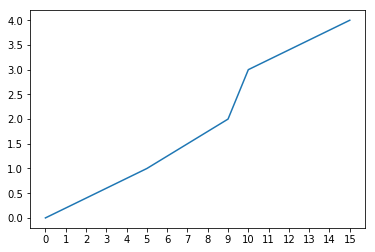

In [612]:
x = [0,5,9,10,15]
y = [0,1,2,3,4]
plt.plot(x,y)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.show()

In [504]:
############################ LINEAR REGRESSION #############################
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from sklearn import linear_model
regr = linear_model.LinearRegression()

X = Xer(train_data, "all")
y = Yer(train_label, 10).reshape(train_label.shape[0],)

# parameters = {}

# grid = GridSearchCV(regr, parameters, cv=2, scoring='explained_variance')
# grid.fit(X, y)

rfecv = RFECV(estimator=regr, step=1, cv=StratifiedKFold(2),
              scoring='neg_mean_squared_error')

rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

/home/vape/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


Optimal number of features : 2


In [508]:

X = Xer(train_data, "all")
X = np.hstack((X[:,1254:1255],X[:,1257:1258]))

y = Yer(train_label, 10).reshape(train_label.shape[0],)

In [528]:
parameters = {}
regr = linear_model.LinearRegression()

grid = GridSearchCV(regr, parameters, cv=2, scoring='neg_mean_squared_error')
grid.fit(X, y)



GridSearchCV(cv=2, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [548]:
############################ NAIVE BAYES #############################
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from sklearn import naive_bayes
nb = naive_bayes.GaussianNB()

X = Xer(train_data, "all")
y = YerCutOff(train_label, 15).reshape(train_label.shape[0],)

# parameters = {}

# grid = GridSearchCV(regr, parameters, cv=2, scoring='explained_variance')
# grid.fit(X, y)

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

liznb = []

for i in range(2,1000):
    X_new = SelectKBest(chi2, k=i).fit_transform(X, y)
    X_new.shape
    
    parameters = {}

    grid = GridSearchCV(nb, parameters, cv=2, scoring='accuracy')
    grid.fit(X_new, y)
    
    liznb.append(grid.grid_scores_[0].mean_validation_score)

In [556]:
# liznb.index(max(liznb))
max(liznb)

0.5176470588235295

In [563]:
from sklearn.metrics import classification_report


X_new = SelectKBest(chi2, k=257).fit_transform(X, y)
X_new.shape

parameters = {}

grid = GridSearchCV(nb, parameters, cv=2, scoring='accuracy')
grid.fit(X_new, y)

predictions = grid.predict(X_new)
print(classification_report(y, predictions))

             precision    recall  f1-score   support

        0.0       0.83      0.40      0.54       178
        1.0       0.37      0.81      0.50        77

avg / total       0.69      0.52      0.53       255



In [564]:
parameters = {}

grid = GridSearchCV(nb, parameters, cv=2, scoring='accuracy')
grid.fit(X_new, y)

GridSearchCV(cv=2, error_score='raise', estimator=GaussianNB(priors=None),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [565]:
grid.grid_scores_[0].mean_validation_score

0.5137254901960784

In [567]:
############################ NEURAL NET CLASSIFICATION #############################
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1)

X = Xer(train_data, "all")
y = YerCutOff(train_label, 15).reshape(train_label.shape[0],)

# parameters = {}

# grid = GridSearchCV(regr, parameters, cv=2, scoring='explained_variance')
# grid.fit(X, y)

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

liznb = []

for i in range(2,1000):
    X_new = SelectKBest(chi2, k=i).fit_transform(X, y)
    X_new.shape
    
    parameters = {}

    grid = GridSearchCV(clf, parameters, cv=2, scoring='accuracy')
    grid.fit(X_new, y)
    
    liznb.append(grid.grid_scores_[0].mean_validation_score)

In [ ]:
############################ NEURAL NET REGRESSION #############################
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from sklearn.neural_network import MLPRegressor
nnr = MLPRegressor(solver='lbfgs', alpha=1e-5, random_state=1)

X = Xer(train_data, "all")
y = YerCutOff(train_label, 15).reshape(train_label.shape[0],)

# parameters = {}

# grid = GridSearchCV(regr, parameters, cv=2, scoring='explained_variance')
# grid.fit(X, y)

rfecv = RFECV(estimator=nnr, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')

rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

In [ ]:
# IDENTIFY BEST FEATURES
liz = list(rfecv.support_)
liz
lizn = [i for i, x in enumerate(liz) if x]

lizn

In [ ]:
############################ SVC #############################
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

X = Xer(train_data, "all")
y = YerCutOff(train_label, 15).reshape(train_label.shape[0],)



## SVM Classify
svc = SVC(kernel="linear")

rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')


rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

In [ ]:
############################ SVR #############################
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

X = Xer(train_data, "all")
y = YerCutOff(train_label, 15).reshape(train_label.shape[0],)


c_range = list(range(1, 10))
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}

svr = SVR()

grid = GridSearchCV(svr, parameters, cv=2, scoring='neg_mean_squared_error')
grid.fit(X, y)



## SVM Classify
svc = SVC(kernel="linear")

rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')


rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

In [ ]:
'''
r2_score' is not a valid scoring value. Valid options are ['accuracy',
'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 
'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 
'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 
'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score',
'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted',
'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']
'''

In [513]:
# predictions = grid.predict(X)
# print(classification_report(y, predictions))
grid.grid_scores_

[mean: -46.27092, std: 1.84876, params: {}]

In [1190]:
X = Xer(train_data, "all")
y = Yer(train_label, 10).reshape(255,)

c_range = list(range(1, 10))
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}

svr = svm.SVR()

grid = GridSearchCV(svr, parameters, cv=2, scoring='neg_mean_squared_error')
grid.fit(X, y)

grid.grid_scores_[0].mean_validation_score

-88.29630716437244

In [410]:
grid.grid_scores_.best

[mean: -80.85133, std: 2.28793, params: {'kernel': 'linear', 'C': 1},
 mean: -45.75654, std: 2.34488, params: {'kernel': 'rbf', 'C': 1},
 mean: -45.66917, std: 2.25271, params: {'kernel': 'poly', 'C': 1},
 mean: -45.97473, std: 2.16432, params: {'kernel': 'sigmoid', 'C': 1},
 mean: -95.42148, std: 4.78920, params: {'kernel': 'linear', 'C': 2},
 mean: -46.17972, std: 2.21070, params: {'kernel': 'rbf', 'C': 2},
 mean: -45.60982, std: 2.13676, params: {'kernel': 'poly', 'C': 2},
 mean: -46.68628, std: 1.87176, params: {'kernel': 'sigmoid', 'C': 2},
 mean: -104.28943, std: 5.26622, params: {'kernel': 'linear', 'C': 3},
 mean: -46.64696, std: 2.14350, params: {'kernel': 'rbf', 'C': 3},
 mean: -45.60144, std: 2.02948, params: {'kernel': 'poly', 'C': 3},
 mean: -47.34204, std: 1.74626, params: {'kernel': 'sigmoid', 'C': 3},
 mean: -112.52939, std: 16.44643, params: {'kernel': 'linear', 'C': 4},
 mean: -47.10370, std: 2.11196, params: {'kernel': 'rbf', 'C': 4},
 mean: -45.55242, std: 1.95335, 

In [394]:
# HYPERTUNER WITH SVR

from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn.feature_selection import SelectFromModel

results = np.zeros((10,7))

def HyperTunerSVM(trainX,trainy):
    
    ftypes = ["au","ig","txt","con","tw","call","all"] # and "all"
    phqscores = [1,2,3,4,5,6,7,8,9,10] # just for readability; 10 is sum
    for i in range(0,len(ftypes)):
        for j in range(0,len(phqscores)):
            
            X = Xer(trainX, ftypes[i])
            y = Yer(trainy, phqscores[j]).reshape(221,)
            
            c_range = list(range(1, 10))
            parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}

            svr = svm.SVR()

            grid = GridSearchCV(svr, parameters, cv=2, scoring='neg_mean_squared_error')
            grid.fit(X, y)

            results[j][i] = grid.grid_scores_[0].mean_validation_score

            
HyperTunerSVM(train_data, train_label)


ValueError: 'ds' is not a valid scoring value. Valid options are ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']

In [391]:
# ZE HYPATUNA

from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn.feature_selection import SelectFromModel

results = np.zeros((10,7))

def HyperTunerSVM(trainX,trainy):
    
    ftypes = ["au","ig","txt","con","tw","call","all"] # and "all"
    phqscores = [1,2,3,4,5,6,7,8,9,10] # just for readability; 10 is sum
    for i in range(0,len(ftypes)):
        for j in range(0,len(phqscores)):
            
            X = Xer(trainX, ftypes[i])
            y = Yer(trainy, phqscores[j]).reshape(221,)
            
            c_range = list(range(1, 10))
            parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}

            svc = svm.SVC()

            grid = GridSearchCV(svc, parameters, cv=2, scoring='accuracy')
            grid.fit(X, y)

            results[j][i] = grid.grid_scores_[0].mean_validation_score

            
HyperTunerSVM(train_data, train_label)


/home/vape/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)
/home/vape/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)
/home/vape/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=2.
  % (min_labels, self.n_folds)), Warning)
/home/vape/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of la

In [393]:
results
df = pd.DataFrame(results, columns=["au","ig","txt","con","tw","call","all"])
df

,au,ig,txt,con,tw,call,all
0,0.298643,0.343891,0.343891,0.334842,0.343891,0.343891,0.294118
1,0.235294,0.357466,0.357466,0.357466,0.357466,0.375566,0.230769
2,0.257919,0.294118,0.294118,0.289593,0.294118,0.280543,0.266968
3,0.285068,0.334842,0.334842,0.307692,0.334842,0.321267,0.262443
4,0.303167,0.330317,0.330317,0.312217,0.330317,0.298643,0.307692
5,0.280543,0.298643,0.298643,0.303167,0.298643,0.289593,0.203620
6,0.280543,0.357466,0.357466,0.339367,0.357466,0.375566,0.271493
7,0.533937,0.592760,0.592760,0.592760,0.592760,0.588235,0.488688
8,0.502262,0.561086,0.561086,0.547511,0.561086,0.556561,0.493213
9,0.040724,0.063348,0.063348,0.063348,0.063348,0.067873,0.049774


In [1]:
# LOG REG

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

results2 = np.zeros((10,7))

def HyperTunerNB(trainX,trainy):
    
    ftypes = ["au","ig","txt","con","tw","call","all"] # and "all"
    phqscores = [1,2,3,4,5,6,7,8,9,10] # just for readability; 10 is sum
    for i in range(0,len(ftypes)):
        for j in range(0,len(phqscores)):
            
            X = Xer(trainX, ftypes[i])
            y = Yer(trainy, phqscores[j]).reshape(221,)
            
            c_range = [0.001,0.01,0.1,0.2,0.3,0.5,0.7,1,2,3,4,5,10,50,100,500,1000,10000]
            parameters = {'C':c_range}

            logistic = LogisticRegression(multi_class='multinomial', solver='newton-cg')


            grid = GridSearchCV(logistic, parameters, cv=2, scoring='accuracy')
            grid.fit(X, y)

            results2[j][i] = grid.grid_scores_[0].mean_validation_score

            
# HyperTunerNB(train_data, train_label)

/home/vape/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/vape/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


NameError: name 'np' is not defined

In [319]:
results2

array([[0.28506787, 0.33936652, 0.33936652, 0.33936652, 0.33936652,
        0.35294118, 0.29411765],
       [0.2760181 , 0.36199095, 0.36199095, 0.36199095, 0.36199095,
        0.36651584, 0.26696833],
       [0.27149321, 0.29864253, 0.29864253, 0.29864253, 0.29864253,
        0.29411765, 0.28959276],
       [0.30769231, 0.32126697, 0.32126697, 0.32126697, 0.32126697,
        0.32126697, 0.29864253],
       [0.25791855, 0.30316742, 0.30316742, 0.30316742, 0.30316742,
        0.30769231, 0.24886878],
       [0.35294118, 0.32579186, 0.32579186, 0.32579186, 0.32579186,
        0.32579186, 0.3438914 ],
       [0.30769231, 0.36651584, 0.36651584, 0.36651584, 0.36651584,
        0.36651584, 0.29864253],
       [0.58823529, 0.58371041, 0.58371041, 0.58371041, 0.58371041,
        0.58371041, 0.58823529],
       [0.54298643, 0.54751131, 0.54751131, 0.54751131, 0.54751131,
        0.54751131, 0.54298643],
       [0.09049774, 0.07692308, 0.07692308, 0.07692308, 0.07692308,
        0.07692308, 0.0

In [324]:
df = pd.DataFrame(results2, columns=["au","ig","txt","con","tw","call","all"])
df

,au,ig,txt,con,tw,call,all
0,0.285068,0.339367,0.339367,0.339367,0.339367,0.352941,0.294118
1,0.276018,0.361991,0.361991,0.361991,0.361991,0.366516,0.266968
2,0.271493,0.298643,0.298643,0.298643,0.298643,0.294118,0.289593
3,0.307692,0.321267,0.321267,0.321267,0.321267,0.321267,0.298643
4,0.257919,0.303167,0.303167,0.303167,0.303167,0.307692,0.248869
5,0.352941,0.325792,0.325792,0.325792,0.325792,0.325792,0.343891
6,0.307692,0.366516,0.366516,0.366516,0.366516,0.366516,0.298643
7,0.588235,0.583710,0.583710,0.583710,0.583710,0.583710,0.588235
8,0.542986,0.547511,0.547511,0.547511,0.547511,0.547511,0.542986
9,0.090498,0.076923,0.076923,0.076923,0.076923,0.076923,0.090498


In [283]:
results2

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
## some plotting business

import matplotlib.pyplot as plt
import pylab
dataframe = pd.DataFrame(mtr)
import seaborn as sns
corr = dataframe.corr()

plot = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
fig = plot.get_figure()
fig.savefig('iamge.png')

In [ ]:
X = Xer(trainX, ftypes[i])
y = Yer(trainy, phqscores[j]).reshape(221,)

c_range = list(range(1, 10))
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}

svc = svm.SVC()

grid = GridSearchCV(svc, parameters, cv=2, scoring='accuracy')
grid.fit(X, y)

results[j][i] = grid.grid_scores_[0].mean_validation_score

In [ ]:
from sklearn.grid_search import GridSearchCV

c_range = list(range(1, 100))
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':c_range}
parameters['kernel']

from sklearn import svm

svc = svm.SVC()

grid = GridSearchCV(svc, parameters, cv=2, scoring='accuracy')
grid.fit(X, y)

grid.grid_scores_

print(grid.grid_scores_[0].parameters)
print(grid.grid_scores_[0].cv_validation_scores)
print(grid.grid_scores_[0].mean_validation_score)

In [302]:
# save matrix as csv. 
import pandas as pd
# np.savetxt("foo.csv", g.featureMatrix , delimiter=",")

# another way

dff = pd.DataFrame(g.featureMatrix)
dff.to_csv("foo.csv")

In [303]:
z = pd.read_csv("foo.csv")
z.shape

(484, 2244)

In [203]:
for i in l.lids()[23:30]:
    b1 = pickle.load( open( "datafor15:20" + "/DP" + i +  "phq" + ".p", "rb" )) 
    print(b1)

['{"Q0":"3","Q1":"1","Q2":"0","Q3":"2","Q4":"0","Q5":"0","Q6":"0","Q7":"0","Q8":"0"}', '{"Q0":"1","Q1":"1","Q2":"0","Q3":"0","Q4":"0","Q5":"0","Q6":"0","Q7":"0","Q8":"0"}']
[]
['{"Q0":"0","Q1":"0","Q2":"0","Q3":"0","Q4":"0","Q5":"0","Q6":"0","Q7":"0","Q8":"0"}']
['{"Q0":"2","Q1":"1","Q2":"0","Q3":"0","Q4":"0","Q5":"0","Q6":"0","Q7":"0","Q8":"0"}']
['{"Q0":"3","Q1":"1","Q2":"3","Q3":"2","Q4":"1","Q5":"3","Q6":"3","Q7":"1","Q8":"0"}']
['{"Q0":"1","Q1":"1","Q2":"3","Q3":"3","Q4":"2","Q5":"2","Q6":"1","Q7":"2","Q8":"1"}']
['{"Q0":"2","Q1":"1","Q2":"1","Q3":"2","Q4":"0","Q5":"2","Q6":"2","Q7":"1","Q8":"2"}']


In [219]:
l.lids()[23:26]

['7276', '6830', '7664']

In [245]:
b1 = pickle.load( open( "datafor16:13" + "/DP" + "6578" +  "text" + ".p", "rb" )) 

print(json.loads(b1[0])["body"])

539833 is your Amazon security code.


In [235]:
apickle = []
exampleLookup = ("7664", "phq")
for row in c.execute('SELECT DISTINCT * FROM data WHERE id=? AND type=? ', exampleLookup):
            
    apickle.append(row[2])
    
    print(row)
    
apickle

('7664', 'phq', '{"Q0":"0","Q1":"0","Q2":"0","Q3":"0","Q4":"0","Q5":"0","Q6":"0","Q7":"0","Q8":"0"}')


['{"Q0":"0","Q1":"0","Q2":"0","Q3":"0","Q4":"0","Q5":"0","Q6":"0","Q7":"0","Q8":"0"}']

In [352]:
b1 = pickle.load( open( "datafor16:13" + "/DP" + "0660" +  "gps" + ".p", "rb" ))
b1

['<?xml version="1.0" encoding="UTF-8"?><kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2"><Document><name> Location history from 2018-01-04 to 2018-01-04 </name><open>1</open><description></description><StyleMap id="multiTrack"><Pair><key>normal</key><styleUrl>#multiTrack_n</styleUrl></Pair><Pair><key>highlight</key><styleUrl>#multiTrack_h</styleUrl></Pair></StyleMap><Style id="multiTrack_n"><IconStyle><Icon><href>https://earth.google.com/images/kml-icons/track-directional/track-0.png</href></Icon></IconStyle><LineStyle><color>99ffac59</color><width>6</width></LineStyle></Style><Style id="multiTrack_h"><IconStyle><scale>1.2</scale><Icon><href>https://earth.google.com/images/kml-icons/track-directional/track-0.png</href></Icon></IconStyle><LineStyle><color>99ffac59</color><width>8</width></LineStyle></Style></Document></kml>\n',
 '<?xml version="1.0" encoding="UTF-8"?><kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/e

In [24]:
import pickle

filedir = './datafor' + '288'

## access example

# instagram = pickle.load( open( filedir + "/DP" + str(int(l.lids()[4])) +  "tweets" + ".p", "rb" )) 

a3 = pickle.load( open( filedir + "/DP" + '1995377' +  "Instagram media" + ".p", "rb" )) 
# a3 = pickle.load( open( filedir + "/DP" + '19671950' +  "Instagram media" + ".p", "rb" )) 
#instagram = pickle.load( open( filedir + "/DP" + '11852603' +  "Instagram" + ".p", "rb" )) 



# json.loads(a3.json()[0])

a3.json()





[]

In [112]:
import requests
import json



# temp = requests.get('http://depressionmqp.wpi.edu:8080/getdata?id=' + str(98945548) + '&type=' + "text")
# fintemp = json.loads(temp.text)["data"]

# while(json.loads(temp.text)["nextURL"] != ''):
#     temp = requests.get('http://depressionmqp.wpi.edu:8080' + json.loads(temp.text)["nextURL"])
#     fintemp += json.loads(temp.text)["data"]

    
fintemp[8817]
    

'{"_id":"4","thread_id":"1","address":" 15085301734","person":"null","date":"1460240309687","date_sent":"0","protocol":"null","read":"1","status":"-1","type":"2","reply_path_present":"null","subject":"null","body":"Your face","service_center":"null","locked":"0","error_code":"0","seen":"1","deletable":"0","sim_slot":"0","sim_imsi":"null","hidden":"0","group_id":"null","group_type":"null","delivery_date":"null","app_id":"0","msg_id":"0","callback_number":"null","reserved":"0","pri":"0","teleservice_id":"0","link_url":"null","svc_cmd":"0","svc_cmd_content":"null","roam_pending":"0","spam_report":"0","safe_message":"0","sub_id":"-1","creator":"com.android.mms","secret_mode":"0","favorite":"0","d_rpt_cnt":"0","using_mode":"0","from_address":"null","announcements_subtype":"0","announcements_scenario_id":"null","device_name":"null"}'

In [525]:
kelsey = {'Valencia':0,'X-Pro II':0, 'Hefe':0, 'Amaro':0, 'Rise':0, 'Willow':0, 'Crema':0, 'Inkwell':0}

# for fil in kelsey:
#     print(kelsey[fil])

'Valencia' in kelsey

True

In [552]:
instagramMedia = pickle.load( open( filedir + "/DP" + '19671950' +  "Instagram media" + ".p", "rb" )) 
filters = {'Lark':0,'Slumber':0, 'Hefe':0, 'Amaro':0, 'Rise':0, 'Willow':0, 'Crema':0, 'Inkwell':0}
filtervec = np.ones((8,))

for i in range(0,3):
    filt = json.loads(a[i])['filter']
    if(filt in filters):
        filters[filt] += 1
    else:
        pass
    
for i in range(0,8):
    filtervec[i] = filters[list(filters)[i]]
    
filtervec

array([ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.])

In [520]:
filtervec = np.ones((8,))
filtervec/4

array([ 0.25,  0.25,  0.25,  0.25,  0.25,  0.25,  0.25,  0.25])

In [143]:
w = embeddingToMastersum(a3)
w.reshape((-1, 1)).T.shape


(1, 300)

In [156]:
timenow  = str(int(time.time())) # for temporal congruency
timenow1 = timenow
timenow1

'1511765588'